
# Binance Trade Data Analysis

## Step 1: Importing Required Libraries
In this section, we will import the necessary libraries for data manipulation, visualization, and statistical analysis.

In [56]:
import pandas as pd
import numpy as np
import ast
import json
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2:Loading the Dataset
In this section we will load the dataset from the given data link.

In [2]:
data_link = 'https://drive.google.com/uc?id=1E3T8i1akfm6NnT42AWEE6U1t7uvwreYK'
data = pd.read_csv(data_link)

In [3]:
data

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."
...,...,...
145,4000222729738650369,"[{'time': 1718982068000, 'symbol': 'ARKMUSDT',..."
146,3998659472131949824,"[{'time': 1718979385000, 'symbol': 'BTCUSDT', ..."
147,4028701921959171840,"[{'time': 1718984241000, 'symbol': 'BTCUSDT', ..."
148,4014818740371615232,"[{'time': 1718983357000, 'symbol': 'SOLUSDT', ..."


## Step 3 :Preparing the Data for EDA
Before diving into Exploratory Data Analysis (EDA), we will convert our dataset into a multi-index DataFrame. This format will enhance our ability to analyze the data by providing a clearer hierarchical structure, allowing us to easily access and manipulate trade details associated with each account.

Why Use a Multi-Index DataFrame? 

Hierarchical Organization: A multi-index allows us to represent multiple dimensions of data (in this case, Port_IDs and Trade_Index) in a single DataFrame. This makes it easier to perform group-based operations and analyses.
Improved Readability: With trades organized under their respective account IDs, it becomes simpler to visualize and interpret the trading activities.
Facilitates EDA: Having data structured in this way allows for more straightforward calculations of metrics such as PnL, ROI, and others during the EDA phase.

In [4]:
data['Trade_History']

0      [{'time': 1718899656000, 'symbol': 'SOLUSDT', ...
1      [{'time': 1718980078000, 'symbol': 'NEARUSDT',...
2      [{'time': 1718677164000, 'symbol': 'ETHUSDT', ...
3      [{'time': 1718678214000, 'symbol': 'ETHUSDT', ...
4      [{'time': 1718979615000, 'symbol': 'ETHUSDT', ...
                             ...                        
145    [{'time': 1718982068000, 'symbol': 'ARKMUSDT',...
146    [{'time': 1718979385000, 'symbol': 'BTCUSDT', ...
147    [{'time': 1718984241000, 'symbol': 'BTCUSDT', ...
148    [{'time': 1718983357000, 'symbol': 'SOLUSDT', ...
149    [{'time': 1718977395000, 'symbol': 'BNBUSDT', ...
Name: Trade_History, Length: 150, dtype: object

In [5]:
def convert_to_multiindex_dataframe(df):
    """
    Convert a DataFrame with trade history columns to a multi-index DataFrame.
    """
    port_ids = []
    trade_details = []
    
    for index, row in df.iterrows():
        port_id = row['Port_IDs']
        trade_history = row['Trade_History']
        
        if pd.isna(trade_history):
            continue
        
        if isinstance(trade_history, str):
            try:
                trade_history = ast.literal_eval(trade_history)
            except (SyntaxError, ValueError):
                try:
                    trade_history = json.loads(trade_history)
                except:
                    print(f"Could not parse trade history for Port ID {port_id}")
                    continue
        
        if not isinstance(trade_history, list):
            print(f"Unexpected trade history format for Port ID {port_id}: {type(trade_history)}")
            continue
        
        for trade in trade_history:
            port_ids.append(port_id)
            trade_details.append(trade)
    
    multi_index_df = pd.DataFrame(trade_details)
    multi_index_df.index = pd.MultiIndex.from_arrays([port_ids, range(len(port_ids))], 
                                                     names=['Port_ID', 'Trade_Index'])
    return multi_index_df

In [6]:
multi_index_df = convert_to_multiindex_dataframe(data)
print(multi_index_df)

                                          time     symbol  side       price   
Port_ID             Trade_Index                                               
3925368433214965504 0            1718899656000    SOLUSDT   BUY  132.537000  \
                    1            1718899618000   DOGEUSDT   BUY    0.121820   
                    2            1718899618000   DOGEUSDT   BUY    0.121820   
                    3            1718899616000   DOGEUSDT   BUY    0.121820   
                    4            1718899616000   DOGEUSDT   BUY    0.121820   
...                                        ...        ...   ...         ...   
3768170840939476993 211272       1718549875000  JASMYUSDT  SELL    0.035968   
                    211273       1718549875000  JASMYUSDT  SELL    0.035968   
                    211274       1718549875000  JASMYUSDT  SELL    0.035969   
                    211275       1718549875000  JASMYUSDT  SELL    0.035969   
                    211276       1718549875000  JASM

In [7]:
multi_index_df

time     symbol  side       price   
Port_ID             Trade_Index                                               
3925368433214965504 0            1718899656000    SOLUSDT   BUY  132.537000  \
                    1            1718899618000   DOGEUSDT   BUY    0.121820   
                    2            1718899618000   DOGEUSDT   BUY    0.121820   
                    3            1718899616000   DOGEUSDT   BUY    0.121820   
                    4            1718899616000   DOGEUSDT   BUY    0.121820   
...                                        ...        ...   ...         ...   
3768170840939476993 211272       1718549875000  JASMYUSDT  SELL    0.035968   
                    211273       1718549875000  JASMYUSDT  SELL    0.035968   
                    211274       1718549875000  JASMYUSDT  SELL    0.035969   
                    211275       1718549875000  JASMYUSDT  SELL    0.035969   
                    211276       1718549875000  JASMYUSDT  SELL    0.035972   

                                      fee feeAsset     quantity quantityAsset   
Port_ID             Trade_Index                                                 
3925368433214965504 0           -0.994027     USDT  1988.055000          USDT  \
                    1           -0.279796     USDT  1398.980880          USDT   
                    2           -0.039494     USDT   197.470220          USDT   
                    3           -0.008284     USDT    16.567520          USDT   
                    4           -0.046109     USDT    92.217740          USDT   
...                                   ...      ...          ...           ...   
3768170840939476993 211272      -0.025070     USDT    50.139392          USDT   
                    211273      -0.008255     USDT    16.509312          USDT   
                    211274      -0.031545     USDT    63.089626          USDT   
                    211275      -0.031905     USDT    63.809006          USDT   
                    211276      -0.005018     USDT    10.036188          USDT   

                                 realizedProfit realizedProfitAsset baseAsset   
Port_ID             Trade_Index                                                 
3925368433214965504 0                       0.0                USDT       SOL  \
                    1                       0.0                USDT      DOGE   
                    2                       0.0                USDT      DOGE   
                    3                       0.0                USDT      DOGE   
                    4                       0.0                USDT      DOGE   
...                                         ...                 ...       ...   
3768170840939476993 211272                  0.0                USDT     JASMY   
                    211273                  0.0                USDT     JASMY   
                    211274                  0.0                USDT     JASMY   
                    211275                  0.0                USDT     JASMY   
                    211276                  0.0                USDT     JASMY   

                                     qty positionSide  activeBuy  
Port_ID             Trade_Index                                   
3925368433214965504 0               15.0         LONG       True  
                    1            11484.0         LONG      False  
                    2             1621.0         LONG      False  
                    3              136.0         LONG       True  
                    4              757.0         LONG       True  
...                                  ...          ...        ...  
3768170840939476993 211272        1394.0         BOTH      False  
                    211273         459.0         BOTH      False  
                    211274        1754.0         BOTH      False  
                    211275        1774.0         BOTH      False  
                    211276         279.0         BOTH      False  

[211277 rows x 14 columns]

Now the Data is Ready for Exploratory Data Analysis (EDA)

## Step 4: Data Cleaning
In this section, we will focus on cleaning the multi-index DataFrame to prepare it for effective Exploratory Data Analysis (EDA). Cleaning involves handling missing values, correcting data types, and ensuring consistency across the dataset.

Before Cleaning the data lets do a initial assesment of the multi-index DataFrame to understand its structure and identify any potential issues.

In [8]:
# Get dimensions of the DataFrame
print("Shape:", multi_index_df.shape)

# Access the levels of the MultiIndex
print("Index Levels:", multi_index_df.index.levels)
print("Index Names:", multi_index_df.index.names)

# Access the column labels
print("Column Labels:", multi_index_df.columns)

Shape: (211277, 14)
Index Levels: [[3672754654734989568, 3733192481840423936, 3768170840939476993, 3784403294629753856, 3786761687746711808, 3788465932399412480, 3818233536529843712, 3819545518395756033, 3826087012661391104, 3858510226868015873, 3865845304835489536, 3878631538480067329, 3879821005658659073, 3880920727367689984, 3886752488982104320, 3887577207880438784, 3891020560590657281, 3907081197088384000, 3910887259807777281, 3910983669796782848, 3911997667197443328, 3914654298562589441, 3919174299855478272, 3923766029921022977, 3925368433214965504, 3926423286576838657, 3930688517098515713, 3931992636670880512, 3932103299427844097, 3935808725185052672, 3936410995029308417, 3937714876784951296, 3939318616482048768, 3939925275039085824, 3941019213896463617, 3942630767220672256, 3943533600390906881, 3944088772635000577, 3944239644144231424, 3944658614777849089, 3946087913459823360, 3949214983441029120, 3949329502284748801, 3951723256343550465, 3952087967771302912, 3953433416230728705

In [9]:
multi_index_df.columns

Index(['time', 'symbol', 'side', 'price', 'fee', 'feeAsset', 'quantity',
       'quantityAsset', 'realizedProfit', 'realizedProfitAsset', 'baseAsset',
       'qty', 'positionSide', 'activeBuy'],
      dtype='object')

In [10]:
multi_index_df.isnull().sum()

time                   0
symbol                 0
side                   0
price                  0
fee                    0
feeAsset               0
quantity               0
quantityAsset          0
realizedProfit         0
realizedProfitAsset    0
baseAsset              0
qty                    0
positionSide           0
activeBuy              0
dtype: int64

By checking for null values in each column, we can determine if any data is missing that might need to be addressed before analysis. Handling missing values is crucial for maintaining the integrity of our analysis.

In [11]:
print(multi_index_df.dtypes)

time                     int64
symbol                  object
side                    object
price                  float64
fee                    float64
feeAsset                object
quantity               float64
quantityAsset           object
realizedProfit         float64
realizedProfitAsset     object
baseAsset               object
qty                    float64
positionSide            object
activeBuy                 bool
dtype: object


Understanding the data types of each column helps ensure that they are appropriate for analysis. For instance, timestamps should be in datetime format, while numerical values should be floats or integers.

### Analyzing Unique Values in Categorical Columns:

In [12]:
#Side Column:
print(multi_index_df['side'].unique())

['BUY' 'SELL']


This command reveals the unique values in the 'side' column, which indicates whether trades are 'BUY' or 'SELL'. Ensuring consistency in these values is important for accurate analysis.

In [13]:
# Symbol Column:
print(multi_index_df['symbol'].unique())

['SOLUSDT' 'DOGEUSDT' 'FILUSDT' 'ETCUSDT' 'BCHUSDT' 'BTCUSDT' 'BNBUSDT'
 'ETHUSDT' 'NEARUSDT' 'JTOUSDT' 'COMPUSDT' 'HOTUSDT' 'WUSDT' 'WIFUSDT'
 '1000PEPEUSDT' 'JASMYUSDT' 'LDOUSDT' 'ORDIUSDT' 'INJUSDT' 'WLDUSDT'
 'DOTUSDT' 'ROSEUSDT' 'ADAUSDT' 'SSVUSDT' 'STXUSDT' '1000FLOKIUSDT'
 'ARUSDT' 'CHZUSDT' '1000BONKUSDT' 'PENDLEUSDT' 'LINKUSDT' '1000SHIBUSDT'
 'AVAXUSDT' 'ONDOUSDT' 'BBUSDT' '1000SATSUSDT' 'ENSUSDT' 'RUNEUSDT'
 'PYTHUSDT' 'IMXUSDT' 'SFPUSDT' 'UMAUSDT' 'MATICUSDT' 'AAVEUSDT' 'SUIUSDT'
 'TIAUSDT' 'BLURUSDT' 'ICPUSDT' 'FTMUSDT' 'FXSUSDT' 'LPTUSDT' 'MANTAUSDT'
 'BIGTIMEUSDT' 'ARKMUSDT' 'CRVUSDT' 'FETUSDT' 'CFXUSDT' 'UNIUSDT'
 'TNSRUSDT' 'XMRUSDT' 'XEMUSDT' 'IOTXUSDT' 'CKBUSDT' 'BOMEUSDT' 'HBARUSDT'
 '1000RATSUSDT' 'ACEUSDT' 'CVXUSDT' 'ENAUSDT' 'RNDRUSDT' 'EOSUSDT'
 'LOOMUSDT' 'AIUSDT' 'ONTUSDT' 'AGIXUSDT' 'XRPUSDT' 'KSMUSDT' 'TRXUSDT'
 'WAVESUSDT' 'LTCUSDT' 'OPUSDT' 'ARBUSDT' 'XAIUSDT' 'APTUSDT' 'SEIUSDT'
 'THETAUSDT' 'IOSTUSDT' 'LQTYUSDT' 'ATOMUSDT' 'SKLUSDT' 'ALGOUSDT'
 'IDUSDT' 

Here, we check the unique trading pairs represented in the dataset (e.g., 'BTCUSDT', 'ETHUSDT'). This helps identify if there are any unexpected symbols or inconsistencies.

In [14]:
# Position Side Column:
print(multi_index_df['positionSide'].unique())

['LONG' 'SHORT' 'BOTH']


This command checks for unique values in the 'positionSide' column, which indicates whether a position is 'LONG', 'SHORT', or 'BOTH'. Consistency in these labels is essential for accurate position analysis.

### Data cleaning

After assessing the dataset, we implemented a cleaning function to preprocess the trading data while preserving the MultiIndex structure.

In [15]:
def clean_trading_data(df):
    """
    Clean and preprocess trading data while preserving the MultiIndex.
    """
    df_cleaned = df.copy()
    df_cleaned['time'] = pd.to_datetime(df_cleaned['time'], unit='ms')
    numeric_columns = ['price', 'fee', 'quantity', 'realizedProfit']
    df_cleaned[numeric_columns] = df_cleaned[numeric_columns].fillna(0)
    df_cleaned = df_cleaned[~df_cleaned.duplicated(subset=['time', 'symbol', 'side', 'price', 'quantity'])]
    df_cleaned.sort_values(by=['time'], inplace=True)
    
    if not isinstance(df_cleaned.index, pd.MultiIndex):
        df_cleaned.set_index(df.index, inplace=True)
    
    return df_cleaned


Key Steps in the Cleaning Function:  
- **Copying Data**: A copy of the original DataFrame is created to avoid altering it directly during cleaning.  
- **Timestamp Conversion**: The time column is converted from milliseconds to a more readable datetime format.  
- **Handling Missing Values**: Missing values in critical numeric columns are filled with zeroes to prevent errors during analysis.  
- **Removing Duplicates**: Duplicate trades are identified and removed based on key attributes such as time, symbol, side, price, and quantity.  
- **Sorting Data**: The cleaned DataFrame is sorted by time to facilitate chronological analysis.  
- **Reconstructing MultiIndex**: If necessary, we ensure that the MultiIndex structure remains intact after cleaning.  

In [16]:
cleaned_data = clean_trading_data(multi_index_df)

In [17]:
cleaned_data

time    symbol  side   
Port_ID             Trade_Index                                       
3932103299427844097 74854       2024-04-22 16:48:03   SOLUSDT  SELL  \
                    74853       2024-04-22 16:48:03   SOLUSDT  SELL   
3939925275039085824 63789       2024-04-22 16:59:56   APTUSDT  SELL   
3949214983441029120 179738      2024-04-22 17:01:18   APTUSDT  SELL   
3788465932399412480 45157       2024-04-22 17:07:27   XRPUSDT  SELL   
...                                             ...       ...   ...   
4021669203289716224 32456       2024-06-21 17:10:23   BTCUSDT  SELL   
3946087913459823360 133791      2024-06-21 17:10:50   RVNUSDT   BUY   
                    133790      2024-06-21 17:11:05   ARBUSDT  SELL   
                    133789      2024-06-21 17:11:11   RVNUSDT  SELL   
                    133788      2024-06-21 17:11:45  ARKMUSDT  SELL   

                                       price       fee feeAsset     quantity   
Port_ID             Trade_Index                                                
3932103299427844097 74854          153.52200 -0.690849     USDT   1381.69800  \
                    74853          153.52200 -0.076761     USDT    153.52200   
3939925275039085824 63789           10.06800 -0.040272     USDT     80.54400   
3949214983441029120 179738          10.08000 -0.012600     USDT     25.20000   
3788465932399412480 45157            0.54660 -0.326129     USDT    652.25778   
...                                      ...       ...      ...          ...   
4021669203289716224 32456        63832.60000 -2.004344     USDT  10021.71820   
3946087913459823360 133791           0.01984 -0.005000     USDT      9.99936   
                    133790           0.80750 -0.005006     USDT     10.01300   
                    133789           0.01983 -0.024698     USDT     49.39653   
                    133788           1.97970 -0.004949     USDT      9.89850   

                                quantityAsset  realizedProfit   
Port_ID             Trade_Index                                 
3932103299427844097 74854                USDT        0.180000  \
                    74853                USDT        0.020000   
3939925275039085824 63789                USDT        0.000000   
3949214983441029120 179738               USDT        0.000000   
3788465932399412480 45157                USDT        2.744590   
...                                       ...             ...   
4021669203289716224 32456                USDT       41.620700   
3946087913459823360 133791               USDT        0.000000   
                    133790               USDT        0.127859   
                    133789               USDT       -0.802668   
                    133788               USDT        0.112000   

                                realizedProfitAsset baseAsset       qty   
Port_ID             Trade_Index                                           
3932103299427844097 74854                      USDT       SOL     9.000  \
                    74853                      USDT       SOL     1.000   
3939925275039085824 63789                      USDT       APT     8.000   
3949214983441029120 179738                     USDT       APT     2.500   
3788465932399412480 45157                      USDT       XRP  1193.300   
...                                             ...       ...       ...   
4021669203289716224 32456                      USDT       BTC     0.157   
3946087913459823360 133791                     USDT       RVN   504.000   
                    133790                     USDT       ARB    12.400   
                    133789                     USDT       RVN  2491.000   
                    133788                     USDT      ARKM     5.000   

                                positionSide  activeBuy  
Port_ID             Trade_Index                          
3932103299427844097 74854               LONG      False  
                    74853               LONG      False  
3939925275039085824 63789   

In [18]:
# Get dimensions of the DataFrame
print("Shape:", cleaned_data.shape)

# Access the levels of the MultiIndex
print("Index Levels:", cleaned_data.index.levels)
print("Index Names:", cleaned_data.index.names)

# Access the column labels
print("Column Labels:", cleaned_data.columns)

Shape: (199740, 14)
Index Levels: [[3672754654734989568, 3733192481840423936, 3768170840939476993, 3784403294629753856, 3786761687746711808, 3788465932399412480, 3818233536529843712, 3819545518395756033, 3826087012661391104, 3858510226868015873, 3865845304835489536, 3878631538480067329, 3879821005658659073, 3880920727367689984, 3886752488982104320, 3887577207880438784, 3891020560590657281, 3907081197088384000, 3910887259807777281, 3910983669796782848, 3911997667197443328, 3914654298562589441, 3919174299855478272, 3923766029921022977, 3925368433214965504, 3926423286576838657, 3930688517098515713, 3931992636670880512, 3932103299427844097, 3935808725185052672, 3936410995029308417, 3937714876784951296, 3939318616482048768, 3939925275039085824, 3941019213896463617, 3942630767220672256, 3943533600390906881, 3944088772635000577, 3944239644144231424, 3944658614777849089, 3946087913459823360, 3949214983441029120, 3949329502284748801, 3951723256343550465, 3952087967771302912, 3953433416230728705

## Step 5 :Conducting EDA

In [19]:
descriptive_stats = cleaned_data.describe()
print(descriptive_stats)

                                time          price            fee   
count                         199740  199740.000000  199740.000000  \
mean   2024-06-03 17:47:55.629032960    3913.943202      -0.395825   
min              2024-04-22 16:48:03       0.000158    -120.458652   
25%              2024-05-23 13:52:57       0.129638      -0.185592   
50%              2024-06-07 12:32:11       2.334200      -0.053345   
75%              2024-06-17 14:47:38      41.245000      -0.009656   
max              2024-06-21 17:11:45   72105.000000       0.000000   
std                              NaN   14979.713703       1.835959   

            quantity  realizedProfit           qty  
count  199740.000000   199740.000000  1.997400e+05  
mean     1011.567987        3.382900  1.138638e+04  
min         0.006694    -3269.194444  1.000000e-03  
25%        23.847531        0.000000  2.000000e+00  
50%       129.940500        0.000000  2.930000e+01  
75%       418.896103        0.602452  6.580000e+02 

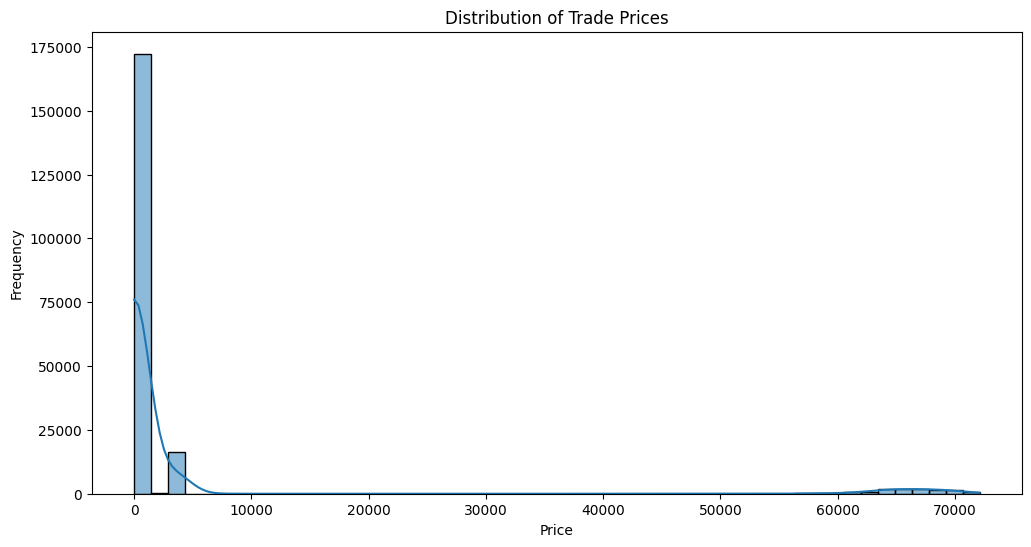

In [20]:
plt.figure(figsize=(12, 6))
sns.histplot(cleaned_data['price'], bins=50, kde=True)
plt.title('Distribution of Trade Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

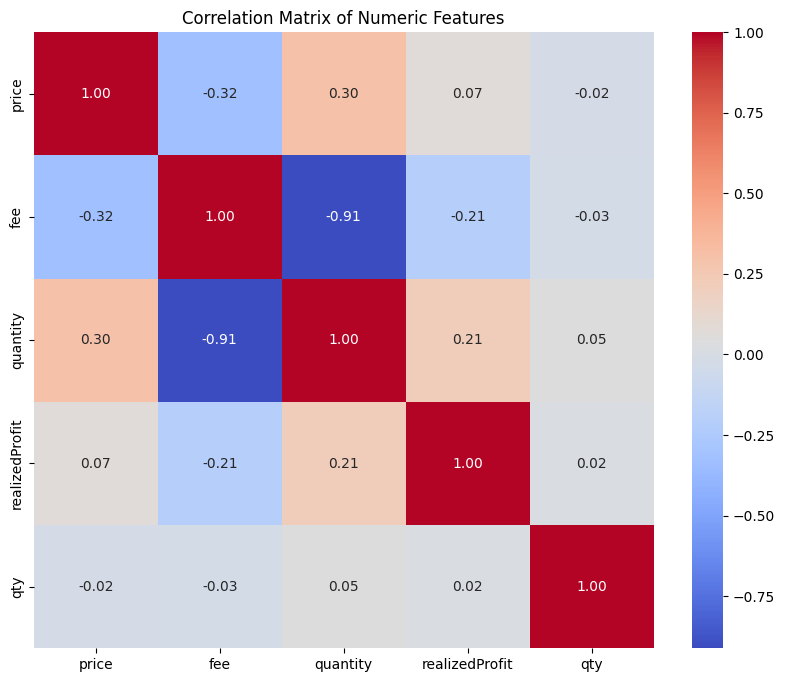

In [21]:
# Select only numeric columns for correlation analysis
numeric_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
correlation_matrix = cleaned_data[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

/var/folders/d0/bg2gd93d5x507wttg3w_pq200000gn/T/ipykernel_64570/3732173119.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=multi_index_df.groupby('time').size(), palette="tab10")


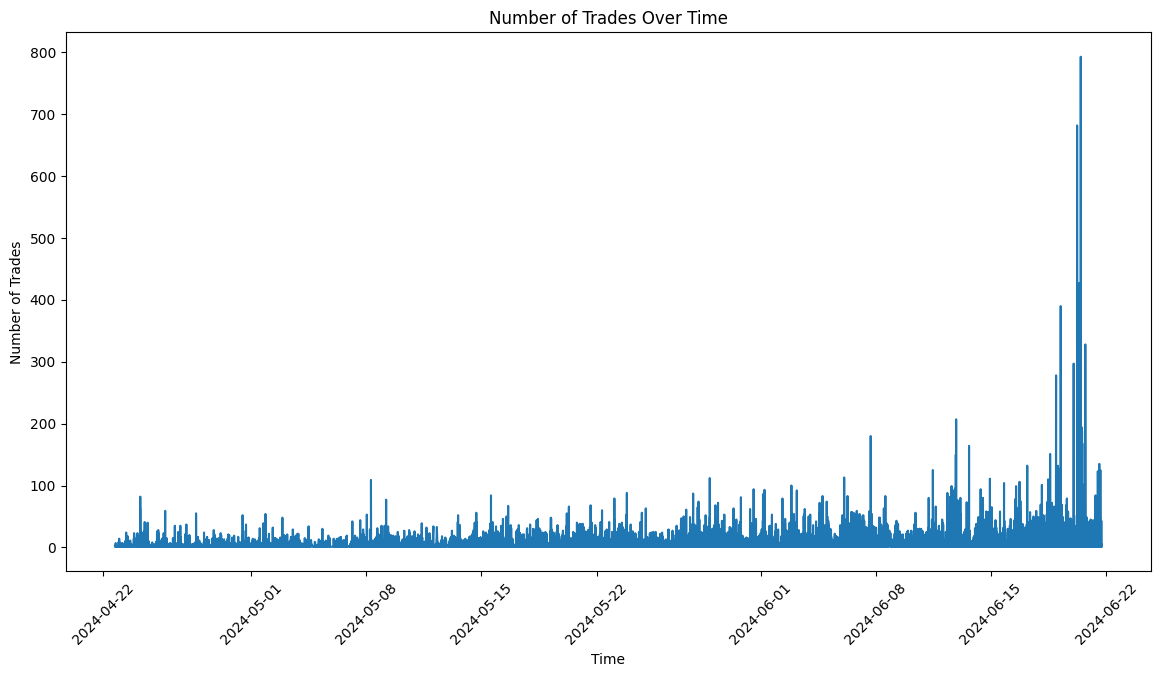

In [22]:
plt.figure(figsize=(14, 7))
multi_index_df['time'] = pd.to_datetime(cleaned_data['time'], unit='ms')  # Ensure time is in datetime format
sns.lineplot(data=multi_index_df.groupby('time').size(), palette="tab10")
plt.title('Number of Trades Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.show()

## Step 6 : Metrics Calculation

### Step 1: Data Preparation and Initial Processing

In this section, we will prepare and clean the trading dataset by adding new features that will aid in performance analysis.


In [23]:
def prepare_trading_data(df):
    """
    Prepare and clean the trading dataset.
    """
    df['trade_type'] = df['side'] + '_' + df['positionSide']
    df['trade_value'] = df['price'] * df['quantity']
    return df


 Explanation

- **Trade Classification**: A new column `trade_type` is created by combining the `side` (BUY/SELL) and `positionSide` (LONG/SHORT) to classify trades more comprehensively.
- **Total Trade Value**: The total value of each trade is calculated by multiplying the price by the quantity, which is stored in a new column called `trade_value`.

In [24]:
processed_df = prepare_trading_data(cleaned_data)

### Step 2: Performance Metrics Calculation
Next, we will define a function to calculate key performance metrics for each account based on its trades.

In [25]:
def calculate_portfolio_metrics(df):
    """
    Calculate comprehensive portfolio-level metrics for each Port_ID.
    """
    portfolio_metrics = []
    
    for port_id, port_data in df.groupby(level='Port_ID'):
        metrics = {
            'Port_ID': port_id,
            'total_trades': len(port_data),
            'total_volume': (port_data['price'] * port_data['quantity']).sum(),
            'total_realized_profit': port_data['realizedProfit'].sum(),
            'avg_trade_profit': port_data['realizedProfit'].mean(),
            'max_single_trade_profit': port_data['realizedProfit'].max(),
            'min_single_trade_profit': port_data['realizedProfit'].min(),
            'win_rate': (port_data['realizedProfit'] > 0).mean(),
            'profit_std_dev': port_data['realizedProfit'].std(),
            'win_positions': (port_data['realizedProfit'] > 0).sum(),
            'loss_positions': (port_data['realizedProfit'] < 0).sum(),
            'long_trades_ratio': (port_data['positionSide'] == 'LONG').mean(),
            'short_trades_ratio': (port_data['positionSide'] == 'SHORT').mean(),
            'roi': (port_data['realizedProfit'].sum() / (port_data['price'] * port_data['quantity']).sum() * 100) 
                  if (port_data['price'] * port_data['quantity']).sum() != 0 else 0
        }
        
        for key, value in metrics.items():
            if isinstance(value, float):
                metrics[key] = 0 if np.isinf(value) or np.isnan(value) else value
        
        portfolio_metrics.append(metrics)
    
    metrics_df = pd.DataFrame(portfolio_metrics)
    return metrics_df


In [26]:
def calculate_maximum_drawdown(df):
    """
    Calculate Maximum Drawdown for each Port_ID.
    """
    mdds = {}
    for port_id, data in df.groupby(level='Port_ID'):
        if data.empty or 'realizedProfit' not in data.columns:
            mdds[port_id] = np.nan  # Skip empty or invalid data
            continue
        
        # Compute cumulative returns
        cumulative_returns = data['realizedProfit'].cumsum()
        
        if cumulative_returns.empty or cumulative_returns.max() == 0:
            mdds[port_id] = 0  # No drawdown if no changes in profit
            continue
        
        # Compute the peak and drawdown
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        
        # Get the minimum drawdown (maximum drop from peak)
        mdds[port_id] = drawdown.min() if not drawdown.isna().all() else 0
    
    # Convert dictionary to a DataFrame column
    mdd_series = pd.Series(mdds, name='mdd')
    return mdd_series


 Explanation

- **Basic Metrics**: The function calculates basic metrics such as total positions, winning positions, and win rate.
- **ROI Calculation**: It computes the Return on Investment (ROI) based on the total investment and realized profit.
- **PnL Calculation**: The Profit and Loss (PnL) is simply the total profit from trades.
- **Maximum Drawdown**: This metric is calculated to assess the largest peak-to-trough decline in cumulative profit.
- **Sharpe Ratio**: This ratio measures risk-adjusted return based on daily returns.

In [27]:
mdds = calculate_maximum_drawdown(processed_df)
mdds

3672754654734989568   -7.517559
3733192481840423936   -1.421625
3768170840939476993    0.000000
3784403294629753856   -0.549546
3786761687746711808   -0.510040
                         ...   
4039279455324236544    0.000000
4040382575336130560    0.000000
4040843843196854529    0.000000
4041804592937345281        -inf
4041860229502600193    0.000000
Name: mdd, Length: 149, dtype: float64

In [28]:
portfolio_metrics = calculate_portfolio_metrics(processed_df)
portfolio_metrics['sharpe_ratio'] = portfolio_metrics['total_realized_profit'] / portfolio_metrics['profit_std_dev']
# Assuming `calculate_maximum_drawdown` returns a Series indexed by Port_ID
mdd_series = calculate_maximum_drawdown(processed_df)

# Map MDD values to portfolio_metrics using Port_ID
portfolio_metrics['mdd'] = portfolio_metrics['Port_ID'].map(mdd_series)


In [29]:
portfolio_metrics

,Port_ID,total_trades,total_volume,total_realized_profit,avg_trade_profit,max_single_trade_profit,min_single_trade_profit,win_rate,profit_std_dev,win_positions,loss_positions,long_trades_ratio,short_trades_ratio,roi,sharpe_ratio,mdd
0,3672754654734989568,461,9.306521e+08,565.547761,1.226785,68.706690,-22.791000,0.446855,6.539488,206,92,0.481562,0.518438,0.000061,86.481960,-7.517559
1,3733192481840423936,585,5.461405e+10,2653.591900,4.536055,501.993000,-1337.271000,0.781197,76.261081,457,7,1.000000,0.000000,0.000005,34.796148,-1.421625
2,3768170840939476993,14,5.799229e+05,243.668899,17.404921,127.078645,0.000000,0.428571,41.022499,6,0,0.000000,0.000000,0.042017,5.939884,0.000000
3,3784403294629753856,5830,3.517349e+08,2526.883798,0.433428,226.653284,-39.614119,0.302916,3.952502,1766,386,0.340652,0.659348,0.000718,639.312486,-0.549546
4,3786761687746711808,79,2.707688e+09,170.220200,2.154686,41.214000,-60.701298,0.430380,11.602348,34,4,0.430380,0.569620,0.000006,14.671186,-0.510040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,4039279455324236544,310,5.408889e+04,1023.498387,3.301608,53.779434,0.000000,0.551613,6.888954,171,0,1.000000,0.000000,1.892253,148.570942,0.000000
145,4040382575336130560,70,1.021142e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,NaN,0.000000
146,4040843843196854529,48,7.509080e+08,2043.478100,42.572460,575.940640,0.000000,0.270833,117.597226,13,0,0.166667,0.833333,0.000272,17.376924,0.000000
147,4041804592937345281,330,1.533237e+09,-796.682686,-2.414190,109.900000,-453.921660,0.227273,28.536118,75,101,0.445455,0.554545,-0.000052,-27.918398,-inf


### Step 3: Feature Importance and Scoring
We will define weights for different performance metrics to create a composite score for ranking accounts.

In [30]:
cleaned_data

time    symbol  side   
Port_ID             Trade_Index                                       
3932103299427844097 74854       2024-04-22 16:48:03   SOLUSDT  SELL  \
                    74853       2024-04-22 16:48:03   SOLUSDT  SELL   
3939925275039085824 63789       2024-04-22 16:59:56   APTUSDT  SELL   
3949214983441029120 179738      2024-04-22 17:01:18   APTUSDT  SELL   
3788465932399412480 45157       2024-04-22 17:07:27   XRPUSDT  SELL   
...                                             ...       ...   ...   
4021669203289716224 32456       2024-06-21 17:10:23   BTCUSDT  SELL   
3946087913459823360 133791      2024-06-21 17:10:50   RVNUSDT   BUY   
                    133790      2024-06-21 17:11:05   ARBUSDT  SELL   
                    133789      2024-06-21 17:11:11   RVNUSDT  SELL   
                    133788      2024-06-21 17:11:45  ARKMUSDT  SELL   

                                       price       fee feeAsset     quantity   
Port_ID             Trade_Index                                                
3932103299427844097 74854          153.52200 -0.690849     USDT   1381.69800  \
                    74853          153.52200 -0.076761     USDT    153.52200   
3939925275039085824 63789           10.06800 -0.040272     USDT     80.54400   
3949214983441029120 179738          10.08000 -0.012600     USDT     25.20000   
3788465932399412480 45157            0.54660 -0.326129     USDT    652.25778   
...                                      ...       ...      ...          ...   
4021669203289716224 32456        63832.60000 -2.004344     USDT  10021.71820   
3946087913459823360 133791           0.01984 -0.005000     USDT      9.99936   
                    133790           0.80750 -0.005006     USDT     10.01300   
                    133789           0.01983 -0.024698     USDT     49.39653   
                    133788           1.97970 -0.004949     USDT      9.89850   

                                quantityAsset  realizedProfit   
Port_ID             Trade_Index                                 
3932103299427844097 74854                USDT        0.180000  \
                    74853                USDT        0.020000   
3939925275039085824 63789                USDT        0.000000   
3949214983441029120 179738               USDT        0.000000   
3788465932399412480 45157                USDT        2.744590   
...                                       ...             ...   
4021669203289716224 32456                USDT       41.620700   
3946087913459823360 133791               USDT        0.000000   
                    133790               USDT        0.127859   
                    133789               USDT       -0.802668   
                    133788               USDT        0.112000   

                                realizedProfitAsset baseAsset       qty   
Port_ID             Trade_Index                                           
3932103299427844097 74854                      USDT       SOL     9.000  \
                    74853                      USDT       SOL     1.000   
3939925275039085824 63789                      USDT       APT     8.000   
3949214983441029120 179738                     USDT       APT     2.500   
3788465932399412480 45157                      USDT       XRP  1193.300   
...                                             ...       ...       ...   
4021669203289716224 32456                      USDT       BTC     0.157   
3946087913459823360 133791                     USDT       RVN   504.000   
                    133790                     USDT       ARB    12.400   
                    133789                     USDT       RVN  2491.000   
                    133788                     USDT      ARKM     5.000   

                                positionSide  activeBuy  trade_type   
Port_ID             Trade_Index                                       
3932103299427844097 74854               LONG      False   SELL_LONG  \
                    74853               LONG   

Handling Problematic Values:

In [31]:
portfolio_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
portfolio_metrics.fillna(portfolio_metrics.mean(), inplace=True)

In [32]:
print(portfolio_metrics.isna().sum())
print(portfolio_metrics[~np.isfinite(portfolio_metrics)].sum())


Port_ID                    0
total_trades               0
total_volume               0
total_realized_profit      0
avg_trade_profit           0
max_single_trade_profit    0
min_single_trade_profit    0
win_rate                   0
profit_std_dev             0
win_positions              0
loss_positions             0
long_trades_ratio          0
short_trades_ratio         0
roi                        0
sharpe_ratio               0
mdd                        0
dtype: int64
Port_ID                    0.0
total_trades               0.0
total_volume               0.0
total_realized_profit      0.0
avg_trade_profit           0.0
max_single_trade_profit    0.0
min_single_trade_profit    0.0
win_rate                   0.0
profit_std_dev             0.0
win_positions              0.0
loss_positions             0.0
long_trades_ratio          0.0
short_trades_ratio         0.0
roi                        0.0
sharpe_ratio               0.0
mdd                        0.0
dtype: float64


In [33]:
def feature_importance_analysis(metrics_df):
    """
    Perform comprehensive feature importance analysis.
    """
    # Drop non-numeric or irrelevant columns
    X = metrics_df.drop(columns=['Port_ID'], errors='ignore')

    # Handle missing/infinite values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)

    # Correlation Matrix
    correlation_matrix = X.corr().abs()

    # Statistical Significance
    statistical_significance = {}
    for column in X.columns:
        if column != 'roi':
            try:
                correlation, p_value = stats.pearsonr(X[column], X['roi'])
                statistical_significance[column] = {
                    'correlation': correlation,
                    'p_value': p_value
                }
            except Exception as e:
                statistical_significance[column] = {'error': str(e)}

    # Machine Learning Feature Importance
    y = X['roi']
    X_for_rf = X.drop(columns=['roi'], errors='ignore')

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_for_rf)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_scaled, y)

    ml_importance = pd.Series(
        rf_model.feature_importances_,
        index=X_for_rf.columns
    ).sort_values(ascending=False)

    return {
        'correlation_matrix': correlation_matrix,
        'statistical_significance': statistical_significance,
        'ml_feature_importance': ml_importance
    }


In [34]:
importance_results = feature_importance_analysis(portfolio_metrics)


In [35]:
importance_results

{'correlation_matrix':                          total_trades  total_volume  total_realized_profit   
 total_trades                 1.000000      0.182170               0.284843  \
 total_volume                 0.182170      1.000000               0.735144   
 total_realized_profit        0.284843      0.735144               1.000000   
 avg_trade_profit             0.187353      0.007118               0.076578   
 max_single_trade_profit      0.063437      0.460843               0.554278   
 min_single_trade_profit      0.185034      0.304671               0.152382   
 win_rate                     0.129670      0.009930               0.153177   
 profit_std_dev               0.191393      0.101165               0.141324   
 win_positions                0.951758      0.120798               0.332662   
 loss_positions               0.726188      0.325907               0.160674   
 long_trades_ratio            0.094501      0.130654               0.106914   
 short_trades_ratio           

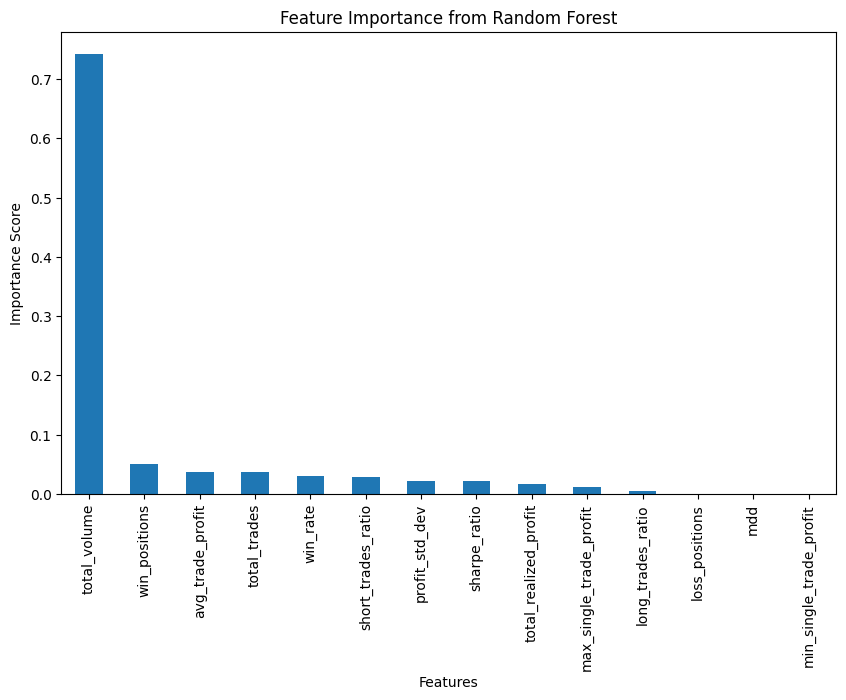

In [36]:
# Plotting feature importances
import matplotlib.pyplot as plt

def plot_feature_importance(importance):
    plt.figure(figsize=(10, 6))
    importance.sort_values(ascending=False).plot(kind='bar')
    plt.title('Feature Importance from Random Forest')
    plt.ylabel('Importance Score')
    plt.xlabel('Features')
    plt.show()

# Call this function after calculating feature importance
plot_feature_importance(importance_results['ml_feature_importance'])

In [49]:
def calculate_composite_score(metrics_df):
    weights = {
        'total_volume': 0.4,
        'win_positions': 0.1,
        'avg_trade_profit': 0.1,
        'total_trades': 0.05,
        'win_rate': 0.1,
        'short_trades_ratio': 0.1,
        'profit_std_dev': 0.05,
        'sharpe_ratio': 0.05,
        'total_realized_profit': 0.02,
        'max_single_trade_profit': 0.01,
        'long_trades_ratio': 0.01,
        'loss_positions': 0.01,
        'mdd': 0.005,
        'min_single_trade_profit': 0.005
    }

    
    scaler = StandardScaler()
    normalized_df = pd.DataFrame(
        scaler.fit_transform(metrics_df.drop(columns=['Port_ID'])), 
        columns=metrics_df.drop(columns=['Port_ID']).columns
    )
    
    composite_score = sum(
        normalized_df[feature] * weight 
        for feature, weight in weights.items()
    )
    
    metrics_df['composite_score'] = composite_score
    metrics_df['rank'] = metrics_df['composite_score'].rank(ascending=False, method='dense')
    return metrics_df.sort_values('composite_score', ascending=False)



Explanation:

This function normalizes each metric based on its type before calculating a composite score using the defined weights.

### Step 4: Main Analysis Function
Finally, we will create a function that ties everything together to analyze trading performance across accounts.

In [50]:
def get_top_accounts(metrics_df, top_n=20):
    ranked_df = calculate_composite_score(metrics_df)
    top_accounts = ranked_df.head(top_n)
    return top_accounts


In [51]:
def main_analysis():
    top_accounts = get_top_accounts(portfolio_metrics)
    
    portfolio_metrics.to_csv("portfolio_metrics.csv")
    top_accounts.to_csv("top_20_accounts.csv")
    
    return {
        'portfolio_metrics': portfolio_metrics,
        'importance_results': importance_results,
        'top_accounts': top_accounts
    }


Explanation
- The `analyze_trading_performance` function prepares data, calculates metrics for each account, ranks them based on their scores, and identifies the top-performing accounts.
- The main function serves as an entry point to execute the analysis and save results.

In [52]:
results = main_analysis()

In [53]:
results['portfolio_metrics']

,Port_ID,total_trades,total_volume,total_realized_profit,avg_trade_profit,max_single_trade_profit,min_single_trade_profit,win_rate,profit_std_dev,win_positions,loss_positions,long_trades_ratio,short_trades_ratio,roi,sharpe_ratio,mdd,composite_score,rank
0,3672754654734989568,461,9.306521e+08,565.547761,1.226785,68.706690,-22.791000,0.446855,6.539488,206,92,0.481562,0.518438,0.000061,86.481960,-7.517559,-0.168769,98.0
1,3733192481840423936,585,5.461405e+10,2653.591900,4.536055,501.993000,-1337.271000,0.781197,76.261081,457,7,1.000000,0.000000,0.000005,34.796148,-1.421625,0.157870,34.0
2,3768170840939476993,14,5.799229e+05,243.668899,17.404921,127.078645,0.000000,0.428571,41.022499,6,0,0.000000,0.000000,0.042017,5.939884,0.000000,-0.363570,133.0
3,3784403294629753856,5830,3.517349e+08,2526.883798,0.433428,226.653284,-39.614119,0.302916,3.952502,1766,386,0.340652,0.659348,0.000718,639.312486,-0.549546,0.226191,26.0
4,3786761687746711808,79,2.707688e+09,170.220200,2.154686,41.214000,-60.701298,0.430380,11.602348,34,4,0.430380,0.569620,0.000006,14.671186,-0.510040,-0.203826,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,4039279455324236544,310,5.408889e+04,1023.498387,3.301608,53.779434,0.000000,0.551613,6.888954,171,0,1.000000,0.000000,1.892253,148.570942,0.000000,-0.235531,112.0
145,4040382575336130560,70,1.021142e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,182.008197,0.000000,-0.684250,149.0
146,4040843843196854529,48,7.509080e+08,2043.478100,42.572460,575.940640,0.000000,0.270833,117.597226,13,0,0.166667,0.833333,0.000272,17.376924,0.000000,-0.122269,86.0
147,4041804592937345281,330,1.533237e+09,-796.682686,-2.414190,109.900000,-453.921660,0.227273,28.536118,75,101,0.445455,0.554545,-0.000052,-27.918398,-3.272413,-0.350675,131.0


In [54]:
results['importance_results']

{'correlation_matrix':                          total_trades  total_volume  total_realized_profit   
 total_trades                 1.000000      0.182170               0.284843  \
 total_volume                 0.182170      1.000000               0.735144   
 total_realized_profit        0.284843      0.735144               1.000000   
 avg_trade_profit             0.187353      0.007118               0.076578   
 max_single_trade_profit      0.063437      0.460843               0.554278   
 min_single_trade_profit      0.185034      0.304671               0.152382   
 win_rate                     0.129670      0.009930               0.153177   
 profit_std_dev               0.191393      0.101165               0.141324   
 win_positions                0.951758      0.120798               0.332662   
 loss_positions               0.726188      0.325907               0.160674   
 long_trades_ratio            0.094501      0.130654               0.106914   
 short_trades_ratio           

In [55]:
results['top_accounts']

,Port_ID,total_trades,total_volume,total_realized_profit,avg_trade_profit,max_single_trade_profit,min_single_trade_profit,win_rate,profit_std_dev,win_positions,loss_positions,long_trades_ratio,short_trades_ratio,roi,sharpe_ratio,mdd,composite_score,rank
96,4020204877254599680,5598,1.275870e+12,70638.371244,12.618501,5520.248820,-1833.670191,0.327260,202.943197,1832,920,0.635763,0.364237,0.000006,348.069668,-0.929646,4.727652,1.0
30,3936410995029308417,19,3.753324e+10,10681.514000,562.184947,8037.002400,0.000000,0.315789,1830.702508,6,0,0.842105,0.157895,0.000028,5.834653,0.000000,1.587009,2.0
99,4022565861939831809,631,3.904109e+11,13807.949797,21.882646,708.617045,-385.075554,0.526149,69.819407,332,17,0.423138,0.576862,0.000004,197.766643,-0.085901,1.345671,3.0
50,3960874214179953664,2231,3.052931e+11,19277.539253,8.640762,855.000000,-1079.638400,0.506051,51.955243,1129,114,0.897355,0.102645,0.000006,371.041268,-0.110203,1.076881,4.0
98,4021669203289716224,1616,2.492246e+11,26438.767142,16.360623,8186.254058,-412.631909,0.316213,234.841534,511,362,0.180074,0.819926,0.000011,112.581308,-3.272413,0.989910,5.0
100,4022641794255717633,6038,6.239069e+05,2173.168186,0.359915,4.110567,-3.183418,0.435409,0.644207,2629,495,0.000000,1.000000,0.348316,3373.399846,-0.163229,0.903413,6.0
107,4028701921959171840,591,2.686497e+11,15750.621514,26.650798,1351.871401,-101.945622,0.500846,96.260273,296,7,0.582064,0.417936,0.000006,163.625356,-0.070314,0.898248,7.0
51,3962024093501274881,1120,3.028221e+11,8848.380864,7.900340,1355.576000,-592.098899,0.255357,104.385613,286,322,0.429464,0.570536,0.000003,84.766287,-86.960220,0.814483,8.0
93,4017263283405469185,5879,1.226856e+11,5975.420992,1.016401,1988.542483,-449.930981,0.335091,39.236312,1970,1635,0.524069,0.475931,0.000005,152.293137,-0.945268,0.656258,9.0
62,3986814617275053313,3390,1.752666e+07,15847.596344,4.674807,510.002882,-1.651618,0.779056,13.990476,2641,2,0.000000,0.000000,0.090420,1132.741745,-0.006969,0.495839,10.0
